<a href="https://colab.research.google.com/github/mmpate15/TeamProject-FoldableRobotics/blob/Zaki-Patel/Sarrus_Dynamics_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Indented block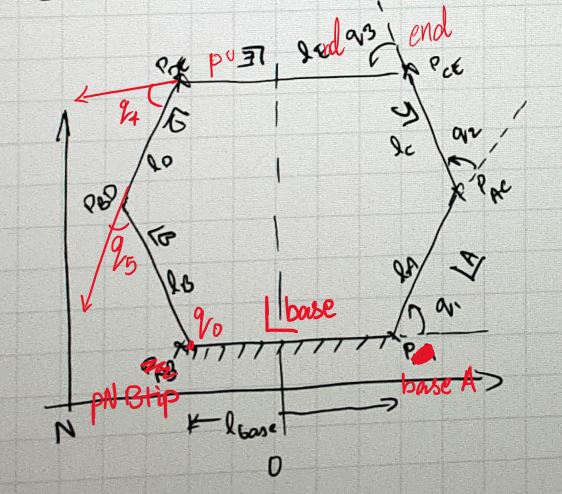



In [ ]:
pip install pynamics

In [ ]:
%matplotlib inline

In [ ]:
use_constraints = True

In [ ]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [ ]:
system = System()
pynamics.set_system(__name__,system)

In [ ]:
#Changed link length ratios
lbase = Constant(2,'lbase',system)
lA = Constant(1,'lA',system)
lC = Constant(1,'lC',system)
lend = Constant(2,'lend',system)
lD = Constant(1,'lD',system)
lB = Constant(1,'lB',system)

#Changed link mass ratio
mbase = Constant(0.04,'mbase',system)
mA = Constant(0.02,'mA',system)
mC = Constant(0.02,'mC',system)
mend = Constant(0.04,'mend',system)
mD = Constant(0.02,'mD',system)
mB = Constant(0.02,'mB',system)

g = Constant(9.81,'g',system)
b = Constant(0,'b',system)
k = Constant(1e1,'k',system)

#Adding spring preloads for all the links
preload0 = Constant(0*pi/180,'preload0',system)
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(10*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(10*pi/180,'preload5',system)


Ixx_base = Constant(0,'Ixx_base',system)
Iyy_base = Constant(0,'Iyy_base',system)
Izz_base = Constant(0,'Izz_base',system)
Ixx_A = Constant(0,'Ixx_A',system)
Iyy_A = Constant(0,'Iyy_A',system)
Izz_A = Constant(0,'Izz_A',system)
Ixx_B = Constant(0,'Ixx_B',system)
Iyy_B = Constant(0,'Iyy_B',system)
Izz_B = Constant(0,'Izz_B',system)
Ixx_C = Constant(0,'Ixx_C',system)
Iyy_C = Constant(0,'Iyy_C',system)
Izz_C = Constant(0,'Izz_C',system)
Ixx_D = Constant(0,'Ixx_D',system)
Iyy_D = Constant(0,'Iyy_D',system)
Izz_D = Constant(0,'Izz_D',system)
Ixx_end = Constant(0,'Ixx_end',system)
Iyy_end = Constant(0,'Iyy_end',system)
Izz_end = Constant(0,'Izz_end',system)


torque = Constant(0,'torque',system)
freq = Constant(3e0,'freq',system)

In [ ]:
#Adding 2 new angles and defining 0 angle
q0,q0_d,q0_dd = Differentiable('q0',system)
q1,q1_d,q1_dd = Differentiable('q1',system)
q2,q2_d,q2_dd = Differentiable('q2',system)
q3,q3_d,q3_dd = Differentiable('q3',system)
q4,q4_d,q4_dd = Differentiable('q4',system)
q5,q5_d,q5_dd = Differentiable('q5',system)

In [ ]:
tol = 1e-5
tinitial = 0
tfinal = 1
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [ ]:
#Adding new initial values and changing the previous ones 
initialvalues = {}
initialvalues[q0] = 0*pi/180
initialvalues[q0_d] = 0*pi/180
initialvalues[q1]=45*pi/180          #Old = 89
initialvalues[q1_d]=0*pi/180
initialvalues[q2]=90*pi/180         #Old = 2
initialvalues[q2_d]=0*pi/180
initialvalues[q3]=45*pi/180           #Old = 89
initialvalues[q3_d]=0*pi/180
initialvalues[q4]=45*pi/180
initialvalues[q4_d]=0*pi/180
initialvalues[q5]=90*pi/180
initialvalues[q5_d]=0*pi/180


In [ ]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [ ]:
# Adding new base frame
N = Frame('N',system)
base = Frame('base',system)
A = Frame('A',system)
C = Frame('C',system)
end = Frame('end',system)
D = Frame('D',system)
B = Frame('B',system)


In [ ]:
system.set_newtonian(N)

In [ ]:
#Changing some angle of rotations and adding new ones
base.rotate_fixed_axis(N,[0,0,1],q0,system)
A.rotate_fixed_axis(base,[0,0,1],q1,system)
C.rotate_fixed_axis(A,[0,0,1],q2,system)
end.rotate_fixed_axis(C,[0,0,1],q3,system)
D.rotate_fixed_axis(end,[0,0,1],q4,system)
B.rotate_fixed_axis(D,[0,0,1],q5,system)

In [ ]:
pNbase= 0*N.x + 0*N.y + 0*N.z
pbaseA = pNbase + lbase*base.x
pAC= pbaseA + lA*A.x
pCend= pAC + lC*C.x
pendD= pCend + lend*end.x
pDB = pendD + lD*D.x
pNBtip = pDB + lB*B.x

In [ ]:
points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]
statevariables = system.get_state_variables()
#eq = [item.subs(constants) for item in eq]
ini0 = [initialvalues[item] for item in statevariables]

In [ ]:
pbasecm= pNbase + lbase/2*base.x
pAcm = pbaseA +lA/2*A.x
pCcm= pAC + lC/2*C.x
pendcm= pCend + lend/2*end.x
pDcm= pendD + lD/2*D.x
pBcm= pDB + lB/2*B.x


In [ ]:
wNbase = N.get_w_to(base)
wbaseA = base.get_w_to(A)
wAC = A.get_w_to(C)
wCend = C.get_w_to(end)
wendD = end.get_w_to(D)
wDB = D.get_w_to(B)


In [ ]:
vNBtip = pNBtip.time_derivative(N,system)

In [ ]:
Ibase = Dyadic.build(N,Ixx_base,Iyy_base,Izz_base)
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
Iend = Dyadic.build(end,Ixx_end,Iyy_end,Izz_end)

Bodybase = Body('Bodybase',base,pbasecm,mbase,Ibase,system)
BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
Bodyend = Body('Bodyend',end,pendcm,mend,Iend,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)

In [ ]:
system.addforce(torque*sympy.sin(freq*2*sympy.pi*system.t)*A.z,wNbase)

In [ ]:
system.add_spring_force1(k,(q0-preload0)*N.z,wNbase)
system.add_spring_force1(k,(q1-preload1)*A.z,wbaseA)
system.add_spring_force1(k,(q2-preload2)*C.z,wAC)
system.add_spring_force1(k,(q3-preload3)*end.z,wCend)
system.add_spring_force1(k,(q4-preload4)*D.z,wendD)
system.add_spring_force1(k,(q5-preload5)*B.z,wDB)

(<pynamics.force.Force at 0x7f356b591990>,
 <pynamics.spring.Spring at 0x7f356b591690>)

In [ ]:
system.addforce(-b*wNbase,wNbase)
system.addforce(-b*wbaseA,wbaseA)
system.addforce(-b*wAC,wAC)
system.addforce(-b*wCend,wCend)
system.addforce(-b*wendD,wendD)
system.addforce(-b*wDB,wDB)

In [ ]:
system.addforcegravity(-g*N.y)

In [ ]:
eq1 = [pNBtip - pNbase]
eq2 = [pDB - pAC]
eq3 = [pNbase - pbaseA]
eq4 = [pendD - pNbase]

In [ ]:
# Converting vector constraints into scalar quantities to make it solvable (Referring back to Solving Nonlinear Four-Bar Constraints Example )

eq = []

# pNBtip and base frame should be in the same x and y axis of N frame
eq.append((eq1[0]).dot(N.x))
eq.append((eq1[0]).dot(N.y))
#eq_d = [system.derivative(item) for item in eq]
#eq_dd = [system.derivative(item) for item in eq_d]

# pCend and pendD should be in the same y axis from Newtonian frame
eq.append((eq2[0]).dot(end.y)) #-----------------------------------------------------Try N

# pNbase and pbaseA are the same distance in y axis from the newtonian frame
eq.append((eq3[0]).dot(N.y))

# pendD and pNbase should have the same distance in x axis from the N frame
#eq.append((eq4[0]).dot(N.x))
    
#Adding Derivative constraints and substituing in the system constants    
eq_d = []
eq_d = [system.derivative(item) for item in eq]
#eq_d = sympy.Matrix(eq_d)
#eq_d = eq_d.subs(system.constant_values)
    
eq_dd = []
eq_dd = [system.derivative(item) for item in eq_d]
#eq_dd = sympy.Matrix(eq_dd)
#eq_dd = eq_dd.subs(system.constant_values)

    
system.add_constraint(AccelerationConstraint(eq_dd))

  
print(eq)

[-lA*sin(q0)*sin(q1) + lA*cos(q0)*cos(q1) + lB*(-(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*sin(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*cos(q2))*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*sin(q3) + (sin(q4)*cos(q5) + sin(q5)*cos(q4))*cos(q3)) + lB*((-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2))*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*cos(q3) - (sin(q4)*cos(q5) + sin(q5)*cos(q4))*sin(q3)) + lC*(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + lC*(-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2) + lD*(-(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*sin(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*cos(q2))*(sin(q3)*cos(q4) + sin(q4)*cos(q3)) + lD*((-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2))*(-sin(q3)*sin(q4) + cos(q3)*cos(q4)) + lbase*cos(q0) + lend*(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*(-sin(q2)*sin(q3) + cos(q2)*cos(q3)) + lend*(-sin(q0)*cos(q1) - sin(q1)*cos(q0))*(sin(q2)*cos(q3) + sin(q3)*cos(q2)), lA*sin(q0)*cos(q1) + lA

In [ ]:
# Identifying independent and dependent variables
qi = [q1]
qd = [q0,q2,q3,q4,q5]

In [ ]:
#Creating dictionary for independent variables
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

In [ ]:
eq = [item.subs(constants) for item in eq]
print(eq)

[((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*sin(q3) + (sin(q4)*cos(q5) + sin(q5)*cos(q4))*cos(q3))*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*cos(q2) - (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*sin(q2)) + ((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*cos(q3) - (sin(q4)*cos(q5) + sin(q5)*cos(q4))*sin(q3))*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*sin(q2) + (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*cos(q2)) + ((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*sin(q2) + (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*cos(q2))*(-sin(q3)*sin(q4) + cos(q3)*cos(q4)) + ((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*cos(q2) - (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*sin(q2))*(sin(q3)*cos(q4) + sin(q4)*cos(q3)) + 2*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))*(-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0)) + 2*(sin(q2)*cos(q3) + sin(q3)*cos(q2))*(-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0)) + (

In [ ]:
error = (numpy.array(eq)**2).sum()
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)


In [ ]:
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

2022-03-04 22:58:39,171 - pynamics.output - INFO - calculating outputs
2022-03-04 22:58:39,174 - pynamics.output - INFO - done calculating outputs


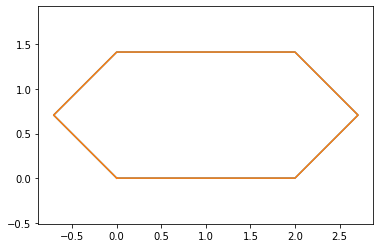

In [ ]:
points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]
points_output = PointsOutput(points, constant_values=system.constant_values)
points_output.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points_output.plot_time()

In [ ]:
f,ma = system.getdynamics()

2022-03-04 22:58:39,367 - pynamics.system - INFO - getting dynamic equations


In [ ]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-03-04 22:58:48,837 - pynamics.system - INFO - solving a = f/m and creating function
2022-03-04 22:58:55,471 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-03-04 22:59:12,784 - pynamics.system - INFO - done solving a = f/m and creating function
2022-03-04 22:59:12,787 - pynamics.system - INFO - calculating function for lambdas


In [ ]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-03-04 22:59:12,797 - pynamics.integration - INFO - beginning integration
2022-03-04 22:59:12,807 - pynamics.system - INFO - integration at time 0000.00
2022-03-04 22:59:44,393 - pynamics.integration - INFO - finished integration


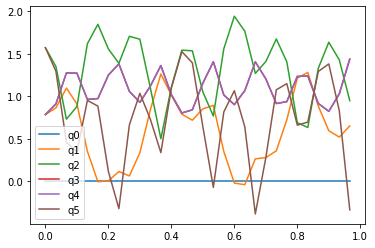

In [ ]:
plt.figure()
artists = plt.plot(t,states[:,:6])
plt.legend(artists,['q0','q1','q2','q3','q4','q5'])

2022-03-04 22:59:45,617 - pynamics.output - INFO - calculating outputs
2022-03-04 22:59:45,657 - pynamics.output - INFO - done calculating outputs


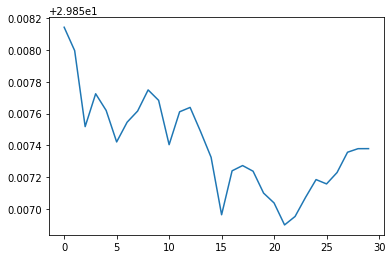

In [ ]:
KE = system.get_KE()
PE = system.getPEGravity(pNbase) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

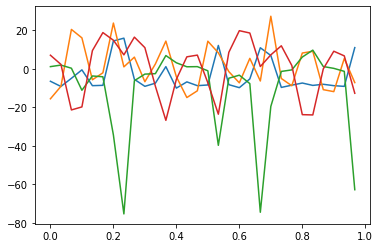

In [ ]:
if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

2022-03-04 22:59:47,571 - pynamics.output - INFO - calculating outputs
2022-03-04 22:59:47,601 - pynamics.output - INFO - done calculating outputs


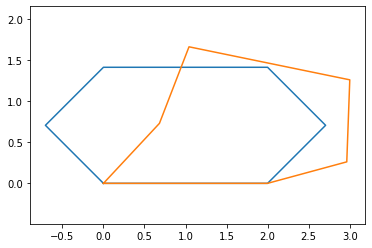

In [ ]:
points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

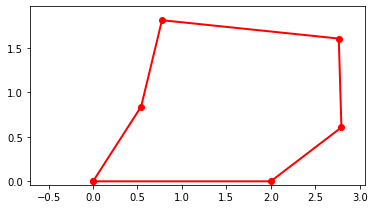

In [ ]:
points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())